In [34]:
;"~/Projects/ASTRAL/soundings/src/"

using Pkg; Pkg.activate("../ASTRAL_soundings")

using Revise
#using Regex
using CSV, DataFrames
using Interpolations
using Dates
using PyPlot

  Activating project at `~/Projects/ASTRAL/soundings/ASTRAL_soundings`


In [18]:
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
stations = ["Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Visakhapatnam"]
hdr = [4,4,4,4,4,4,7] # 7 header lines for Vsk, 4 for others

# dates are formatted a variety of different ways

#datematcher = ["yyyymmdd-HH", "ddUyyyy", "dduuuyy"]
#ldm = length.(datematcher)
#datefm = Dates.DateFormat.(datematcher)
# doesn't handle undelimited month names

"Parse the various date formats in the file names. Only works for May or 3-letter month."
function imd_file_date(fn)
    if fn[1:6]=="43150-" && all(isnumeric, fn[[7:14; 16:17]]) # 43150 Visakhap. WMO station ID
        dt = Dates.DateTime(fn[7:17], "yyyymmdd-HH")
    elseif fn[10:12]=="VSK" && all(isnumeric, fn[[1:2; 6:9]])  # Visakhap.
        dt = Dates.DateTime(fn[1:9], "ddUUUyyyy")
    elseif all(isnumeric, fn[[1:8; 10:11]])
        dt = Dates.DateTime(fn[1:11], "yyyymmdd-HH")
    else
        if all(isnumeric, fn[[1:2; 6:7]])
            if isletter(fn[8])
                dt = DateTime( 2000+year(DateTime(fn[6:7], "yy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            elseif all(isnumeric, fn[8:9])
                dt = DateTime( year(DateTime(fn[6:7], "yyyy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            end
        end
    end
    return dt
end


33-element Vector{String}:
 "01MAY2023VSK.txt"
 "02MAY2023VSK.txt"
 "03MAY2023VSK.txt"
 "04MAY2023VSK.txt"
 "05MAY2023VSK.txt"
 "06MAY2023VSK.txt"
 "07MAY2023VSK.txt"
 "08MAY2023VSK.txt"
 "09MAY2023VSK.txt"
 "10MAY2023VSK.txt"
 "43150-20230501-00-Standard-Summary.txt"
 "43150-20230502-00-Standard-Summary.txt"
 "43150-20230503-00-Standard-Summary.txt"
 ⋮
 "43150-20230512-00-Standard-Summary.txt"
 "43150-20230513-00-Standard-Summary.txt"
 "43150-20230514-00-Standard-Summary.txt"
 "43150-20230515-00-Standard-Summary.txt"
 "43150-20230516-00-Standard-Summary.txt"
 "43150-20230517-00-Standard-Summary.txt"
 "43150-20230518-00-Standard-Summary.txt"
 "43150-20230519-00-Standard-Summary.txt"
 "43150-20230520-00-Standard-Summary.txt"
 "43150-20230521-00-Standard-Summary.txt"
 "43150-20230522-00-Standard-Summary.txt"
 "43150-20230523-00-Standard-Summary.txt"

In [27]:
stationdir = lowercase(stations[7]) # lowercase("Visakhapatnam")

# read standard named files in the station's directory
files = filter(x -> occursin(r"(?i)(May|Standard).*(\.txt)$(?-i)",x),
               readdir(joinpath(reldatapath, stationdir)) ) 

# remove duplicate times uniqueidx(v) = unique(i -> v[i], eachindex(v))
uniqueidx(v) = unique(i -> v[i], eachindex(v))

fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order
collect(zip(fdt[ui[ord]], files[ui[ord]]))

23-element Vector{Tuple{DateTime, String}}:
 (DateTime("2023-05-01T00:00:00"), "01MAY2023VSK.txt")
 (DateTime("2023-05-02T00:00:00"), "02MAY2023VSK.txt")
 (DateTime("2023-05-03T00:00:00"), "03MAY2023VSK.txt")
 (DateTime("2023-05-04T00:00:00"), "04MAY2023VSK.txt")
 (DateTime("2023-05-05T00:00:00"), "05MAY2023VSK.txt")
 (DateTime("2023-05-06T00:00:00"), "06MAY2023VSK.txt")
 (DateTime("2023-05-07T00:00:00"), "07MAY2023VSK.txt")
 (DateTime("2023-05-08T00:00:00"), "08MAY2023VSK.txt")
 (DateTime("2023-05-09T00:00:00"), "09MAY2023VSK.txt")
 (DateTime("2023-05-10T00:00:00"), "10MAY2023VSK.txt")
 (DateTime("2023-05-11T00:00:00"), "43150-20230511-00-Standard-Summary.txt")
 (DateTime("2023-05-12T00:00:00"), "43150-20230512-00-Standard-Summary.txt")
 (DateTime("2023-05-13T00:00:00"), "43150-20230513-00-Standard-Summary.txt")
 (DateTime("2023-05-14T00:00:00"), "43150-20230514-00-Standard-Summary.txt")
 (DateTime("2023-05-15T00:00:00"), "43150-20230515-00-Standard-Summary.txt")
 (DateTime("2023-05-1

In [100]:
# Interpolation methods
# Pressure is irregular and different for each sounding time.

"dv converts Datetimes to numeric values for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Filter missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"rectangular interval averaging onto a decreasing pressure coordinate"
function pavg(x::Vector, p::Vector; plevs=1020.0:-20.0:0.0)
    s1 = zeros(Float64, size(plevs))
    # s2 = zeros(Float64, size(p))
    ns = zeros(Float64, size(plevs))
    
    for i in eachindex(p)
        j = findfirst(x -> x < p[i], plevs) # j indexes plevs
        s1[j] += isfinite(x[i]) ? x[i] : 0
        # s2[j] += x[i]^2
        ns[j] += 1.0*isfinite(x[i])
    end
    
    s1 ./ ns # mean
end

pavg

In [101]:
# 1 file example

station = lowercase("visakhapatnam")
files = filter(x -> occursin(r"(?i)(May|Standard).*(\.txt)$(?-i)",x),
               readdir(joinpath(reldatapath, station) ))
# dt = imd_file_date(files[ui[ord[8]]])

# deduplicate sounding times
fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order

# reader functions
striptabs(f) = IOBuffer(replace(read(f), UInt8('\t') => UInt8(' ')))
function read_sonde(file; header=( station=="visakhapatnam" ? 7 : 3 ) )
    CSV.read( striptabs(file), DataFrame, header=header, 
        stripwhitespace=true, 
        delim="," )
end

df = read_sonde( joinpath(reldatapath, station, files[ui[ord[8]]]),
                 header=( station=="visakhapatnam" ? 7 : 3 )      )


┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577


Row,Time,P(hPa),T(C),U(%),Dew(C),Geo(gpm),Geo(gpft),Wdir(d),Wspd(m/s),Asc(m/m),AvgAsc(m/m),Column12
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Missing
1,000:00.00,999.1,29.0,89.0,27.0,60.0,196.9,240.0,1.0,0.0,0.0,missing
2,000:01.00,998.9,28.6,87.4,26.3,60.9,199.9,240.4,1.0,64.0,55.6,missing
3,000:02.00,998.5,28.5,87.3,26.2,64.1,210.3,240.9,1.1,189.4,121.9,missing
4,000:03.00,998.1,28.5,87.3,26.2,68.3,224.1,241.3,1.1,197.2,165.9,missing
5,000:04.00,997.5,28.4,87.3,26.1,73.3,240.5,241.6,1.1,226.3,199.2,missing
6,000:05.00,997.0,28.4,87.3,26.1,78.2,256.6,242.0,1.2,242.4,218.1,missing
7,000:06.00,996.4,28.4,87.4,26.0,82.8,271.7,242.3,1.2,242.9,227.8,missing
8,000:07.00,996.0,28.3,87.4,26.0,87.2,286.0,242.7,1.2,244.9,232.6,missing
9,000:08.00,995.5,28.3,87.4,26.0,91.3,299.7,243.0,1.2,246.0,234.8,missing


In [102]:
# data into individual arrays - Visakahpatnam style
p = df[!,"P(hPa)"][:]
T = df[!,"T(C)"][:]
rh = df[!,"U(%)"][:]
Td = df[!,"Dew(C)"][:]
z = df[!,"Geo(gpm)"][:]
wspd = df[!,"Wspd(m/s)"][:]
wdir = df[!,"Wdir(d)"][:]
u = wspd .* sind.(wdir)
v = wspd .* cosd.(wdir)

5155-element Vector{Float64}:
 -0.5
 -0.4939418665842309
 -0.5349689184658395
 -0.5282458471875077
 -0.5231866299773029
 -0.5633658753430689
 -0.5578104548695433
 -0.5503794653811781
 -0.5447885996874562
 -0.5861408028962602
 -0.5800571570427514
 -0.5719209208126896
 -0.604920048322775
  ⋮
  4.248184473117211
  4.167948325240645
  4.098678878363689
  4.028959965159807
  3.9705230428528964
  3.87325358905281
  3.826699499912176
  3.7916614127966968
  3.7565193753682418
  3.696148891218528
  3.6845531138721612
  3.6729461127380176

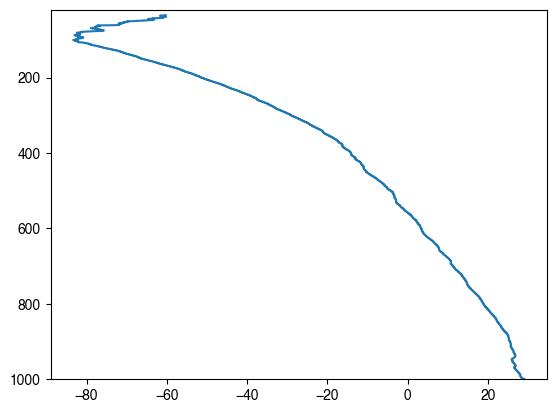

(1000.0, 20.0)

In [103]:
clf()
plot( T,p, label="Temperature (C)")
ylim(1000, 20)


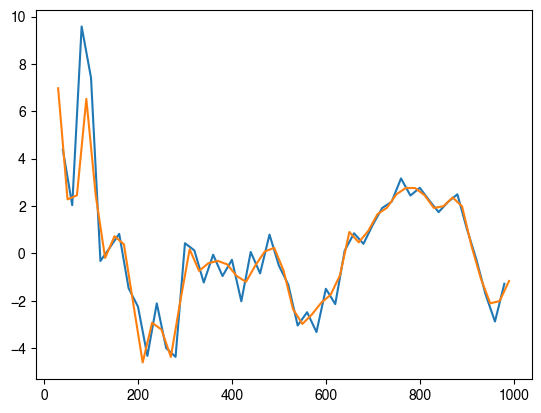

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8382a59550>

In [108]:
# pressure levels to interploate to

upi = uniqueidx(p)

# test interpolation
plot(plevs, itp(u[upi], p[upi])[plevs])
# test averaging
# plot(plevs, pavg(u, p plevs=plevs))

plevs = 1020.0:-20.0:0.0
u_pl = pavg(u, p, plevs=plevs)
# plev is the level geometrically above and dynamically (pressure) below the binned observations
# probably suitable for pcolormesh
plot(plevs.+10, u_pl)

In [110]:
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-20.0:0.0

CamelNames = ["Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Visakhapatnam"]

7-element Vector{String}:
 "Chennai"
 "Karaikal"
 "Kochi"
 "Kolkata"
 "Mangalore"
 "PortBlair"
 "Visakhapatnam"

In [112]:
stationnames = lowercase.(CamelNames)
stationnames[7]

"visakhapatnam"

In [113]:
T  = zeros(Float64, length(plevs), length(stationnames), length(ord))
rh = zeros(Float64, length(plevs), length(stationnames), length(ord))
Td = zeros(Float64, length(plevs), length(stationnames), length(ord))

sj = 0
for station in [stationnames[7]]
    # read standard named files in the station's directory
    files = filter(x -> occursin(r"(?i)(May|Standard).*(\.txt)$(?-i)",x),
                   readdir(joinpath(reldatapath, lowercase(station))) )
    sj += 1 # gridded station index
    # deduplicate sounding times
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    #collect(zip( files[ui[ord]]], fdt[ui[ord]] ))
    
    tj=0
    for ti in ui[ord]
        df = read_sonde( joinpath(reldatapath, station, files[ti]),
                 header=( station=="visakhapatnam" ? 7 : 3 )      )
        p = df[!,"P(hPa)"]
        # avg variables at the next time level
        tj += 1
        T[  :, sj, tj] .= pavg(df[!,"T(C)"  ], p, plevs=plevs)
        rh[ :, sj, tj] .= pavg(df[!,"U(%)"  ], p, plevs=plevs)
        Td[ :, sj, tj] .= pavg(df[!,"Dew(C)"], p, plevs=plevs)
        
        # u[  :, sj, tj] .= pavg(df[!,"T(C)"  ], p, plevs=plevs)
        # v[  :, sj, tj] .= pavg(df[!,"T(C)"  ], p, plevs=plevs)
    end
end

┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/7lFhM/src/file.jl:577
┌ Warning: thread = 1 warning: parsed expected 11 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columns

LoadError: ArgumentError: column name :P(hPa) not found in the data frame

In [ ]:


for file in files[ui[ord]]
    